In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from typing import List, Dict
from tqdm.autonotebook import tqdm

import os
import time
import openai
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
openai.api_key = 'OPENAI_KEY'

In [2]:
def preprocess_annotations(df):
    accept_mask = df['answer'] == 'accept'
    cols = ['text', 'accept']
    df_prep = df.loc[accept_mask, cols]
    df_prep['accept'] = df_prep['accept'].apply(set)
    df_prep['accept'] = df_prep['accept'].apply(list)
    df_prep.reset_index(drop=True)
    
    return df_prep

def tokenize_labels(labels: List[str]) -> List[str]:
    """
    Converts a list of labels into a list of GPT-3 tokens.
    Adds preceding whitespace as needed in order to account for
    quirks in how GPT-3 handles tokenization.
    """
    # Start with whitespace tokens
    tokens = []
    tokens += tokenizer.encode(" ")
    tokens += tokenizer.encode("\n")
    tokens += tokenizer.encode(",")
    # Tokenize each label by itself *and* with a preceding space.
    for label in labels:
        tokens += tokenizer.encode(label)
        tokens += tokenizer.encode(" " + label)

    return tokens

def make_promt_with_examples(text, examples):
    promt = "Classify the text in 6 not exclusive categories: " \
            "harassment, theft, robbery, auto theft, assault, homicide. If any category suits classify none \n"
    for t, cats in examples:
        promt += "Text: " + t + "\n" + "Categories: " + cats + "\n\n" 
    promt += "Text: " + text + "\n" + "Categories:"
    
    return promt

def make_promt(text):
    #promt = "Classify the text in 6 not exclusive categories: " \
    #
    #"harassment, theft, robbery, auto_theft, assault, homicide, If any category suits classify none \n" 
    promt = """Classify the text in 6 not exclusive categories: harassment, theft, robbery, auto theft, assault, and homicide. If any category suits classify none

Text: Next up in Example video title will go here for this video TEMPLE, Texas -- Rockdale Police Department assisted in locating 31-year-old Justin Glenn Boswell, according to their Facebook. Saturday morning Rockdale Police Officer Lauren Hensley arrested Boswell on Highway 77 overpass at US 79 without any issues, according to police. Boswell was wanted for the murder of 25-year-old Rowdy Mays who was reportedly stabbed and killed by a hitchhiker in Temple on July 28. Temple Police said Mays was found in the 2600 block of S. Martin Luther King Drive around 6:15 p.m. Mays picked up Boswell, who then stabbed him and stole his vehicle, police said. His vehicle was later found that night in Rockdale, Texas. 6 News will keep you updated when more information is released.
Categories: auto theft, homicide

Text: The American-majority team will now go up against in the upper bracket final. posted their first win at BLAST Premier Fall Groups by taking down 16-12 on Mirage. A North American derby awaits , who will now face off against in the upper bracket final for a chance to secure a group final berth. had an impressive game, carrying his squad to victory on the back of a 26-18 KD and 1.37 rating. , meanwhile, have been sent down to the lower bracket. The European team will battle it out with at to have a shot at running the Group B gauntlet. started the map on the CT side, shutting down a play by on the B site to steal away the pistol round. Strong heroics from spurred the North American roster on, with eventually taking the lead mid-way through the half at 5-4. Unrelenting CT aggression by the European mix proved to be too much for and company to handle, and soon found themselves heading into the break one round up. The -led lineup extended their lead even further by snatching the first three rounds of the half, but continued to be a stalwart for on the CT side, consistently keeping his foes at bay as the American-majority roster retook the lead, 14-12. In the end took care of business, winning a round on the A-site that came down to the wire to hit match point before nailing the coffin shut in a successful 3vs2 retake.
Categories: none\n"""
    
    promt += "Text: " + text + "\n" + "Categories:"
    
    return promt

def get_logit_bias(labels: List[str]) -> Dict[str, float]:
    """
    Returns a logit_bias that can be used to constrain GPT-3
    predictions to a set of pre-determined character sequences
    (i.e. phrases or words). Intended to be used for classification
    problems.
    """
    tokens = tokenize_labels(labels)
    logit_bias: Dict[str, float] = {}
    for token in set(tokens):
        # Set the logit_bias for each token to 100, effectively
        # forcing GPT-3 to only choose from these tokens.
        logit_bias[str(token)] = 100
    return logit_bias

def make_request(promt, logit_bias=False):
    if logit_bias:
        response = openai.Completion.create(
            model="text-davinci-003",
            prompt=promt,
            temperature=0,
            logit_bias=get_logit_bias(LABELS),
            logprobs=5
        )
    else: 
        response = openai.Completion.create(
            model="text-davinci-003",
            prompt=promt,
            temperature=0,
            logprobs=5
    )
    return response["choices"]

LABELS = ["harassment", "theft", "robbery", "auto theft", "assault", "homicide"]

In [3]:
t = """Classify the text in 6 not exclusive categories: harassment, theft, robbery, auto theft, assault, and homicide. If any category suits classify none

Text: Next up in Example video title will go here for this video TEMPLE, Texas -- Rockdale Police Department assisted in locating 31-year-old Justin Glenn Boswell, according to their Facebook. Saturday morning Rockdale Police Officer Lauren Hensley arrested Boswell on Highway 77 overpass at US 79 without any issues, according to police. Boswell was wanted for the murder of 25-year-old Rowdy Mays who was reportedly stabbed and killed by a hitchhiker in Temple on July 28. Temple Police said Mays was found in the 2600 block of S. Martin Luther King Drive around 6:15 p.m. Mays picked up Boswell, who then stabbed him and stole his vehicle, police said. His vehicle was later found that night in Rockdale, Texas. 6 News will keep you updated when more information is released.
Categories: auto theft, homicide

Text: The American-majority team will now go up against in the upper bracket final. posted their first win at BLAST Premier Fall Groups by taking down 16-12 on Mirage. A North American derby awaits , who will now face off against in the upper bracket final for a chance to secure a group final berth. had an impressive game, carrying his squad to victory on the back of a 26-18 KD and 1.37 rating. , meanwhile, have been sent down to the lower bracket. The European team will battle it out with at to have a shot at running the Group B gauntlet. started the map on the CT side, shutting down a play by on the B site to steal away the pistol round. Strong heroics from spurred the North American roster on, with eventually taking the lead mid-way through the half at 5-4. Unrelenting CT aggression by the European mix proved to be too much for and company to handle, and soon found themselves heading into the break one round up. The -led lineup extended their lead even further by snatching the first three rounds of the half, but continued to be a stalwart for on the CT side, consistently keeping his foes at bay as the American-majority roster retook the lead, 14-12. In the end took care of business, winning a round on the A-site that came down to the wire to hit match point before nailing the coffin shut in a successful 3vs2 retake.
Categories: none\n"""

print(t)

Classify the text in 6 not exclusive categories: harassment, theft, robbery, auto theft, assault, and homicide. If any category suits classify none

Text: Next up in Example video title will go here for this video TEMPLE, Texas -- Rockdale Police Department assisted in locating 31-year-old Justin Glenn Boswell, according to their Facebook. Saturday morning Rockdale Police Officer Lauren Hensley arrested Boswell on Highway 77 overpass at US 79 without any issues, according to police. Boswell was wanted for the murder of 25-year-old Rowdy Mays who was reportedly stabbed and killed by a hitchhiker in Temple on July 28. Temple Police said Mays was found in the 2600 block of S. Martin Luther King Drive around 6:15 p.m. Mays picked up Boswell, who then stabbed him and stole his vehicle, police said. His vehicle was later found that night in Rockdale, Texas. 6 News will keep you updated when more information is released.
Categories: auto theft, homicide

Text: The American-majority team will 

In [4]:
fpath = r'C:\ProjectX\workspace\data\data_providers\gdelt\scraped_news\usa-news-annotated.jsonl'
df = pd.read_json(fpath, lines=True, encoding='utf-16')
df.head()

,text,_input_hash,_task_hash,spans,meta,options,accept,_view_id,config,answer,_timestamp
0,"By Jennifer De Pinto, Fred Backus, Anthony Sal...",1998789611,-135893388,"[{'text': 'gun', 'start': 485, 'end': 488, 'pa...","{'pattern': '61, 61, 61, 61, 61, 57, 61, 61, 6...","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666862735
1,The epic decision by the US Supreme Court decl...,-1364136101,-553694219,"[{'text': 'gun', 'start': 234, 'end': 237, 'pa...","{'pattern': '61, 61, 61'}","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666862983
2,"Governor Kathy Hochul has called for an ""extra...",1645904776,555948591,"[{'text': 'gun', 'start': 88, 'end': 91, 'patt...","{'pattern': '61, 58, 61, 60, 61, 60, 60, 58, 5...","[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863272
3,"CHARLESTON, W.Va. (WV News) -- West Virginia l...",-616248505,-97240494,"[{'text': 'obscene', 'start': 3021, 'end': 302...",{'pattern': '21'},"[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863386
4,"""For the first time now, in this pandemic, nea...",2145160317,1081617857,"[{'text': 'threat', 'start': 1362, 'end': 1368...",{'pattern': '9'},"[{'id': 'HARASSMENT', 'text': 'HARASSMENT'}, {...",[],choice,{'choice_style': 'multiple'},accept,1666863439


In [5]:
df_prep = preprocess_annotations(df)
#df_prep['text'] = df_prep['text'].apply(preprocess_text)
df_prep.head()

,text,accept
0,"By Jennifer De Pinto, Fred Backus, Anthony Sal...",[]
1,The epic decision by the US Supreme Court decl...,[]
2,"Governor Kathy Hochul has called for an ""extra...",[]
3,"CHARLESTON, W.Va. (WV News) -- West Virginia l...",[]
4,"""For the first time now, in this pandemic, nea...",[]


In [6]:
def preprocess_predict(predict):
    possible_labels = ["harassment", "theft", "robbery", "auto theft", "assault", "homicide"]
    
    labels = [l.strip().lower() for l in predict.split(', ')]
    labels = [l for l in labels if l in possible_labels]
    
    return labels

def predict_on_df(df):
    errors = []
    df_prep = df.copy()
    for i in tqdm(df.index):
        try:
            resp = make_request(make_promt(df_prep.loc[i, "text"]))[0]["text"]
            df_prep.loc[i, "suggested"] = preprocess_predict(resp)
        except Exception as ex:
            time.sleep(5)
            print(i)
            #print(ex)
            errors.append(i)
    return df_prep, errors

In [7]:
sample_idx = df_prep.sample(5).index
for i in sample_idx:
    print("True: ", df_prep.loc[i, 'accept'])
    resp = make_request(make_promt(df_prep.loc[i, "text"]))[0]["text"]
    print("Predicted: ", preprocess_predict(resp))

True:  ['HOMICIDE']
Predicted:  ['homicide', 'assault']
True:  []
Predicted:  []
True:  ['ROBBERY', 'HOMICIDE']
Predicted:  ['homicide', 'robbery', 'theft']
True:  []
Predicted:  []
True:  []
Predicted:  ['theft', 'auto theft']


In [14]:
errors = []
for i in tqdm(df_prep.index):
    try:
        resp = make_request(make_promt(df_prep.loc[i, "text"]))[0]["text"]
        df_prep.loc[i, "suggested"] = preprocess_predict(resp)
    except Exception as ex:
        time.sleep(5)
        print(i)
        print(ex)
        errors.append(i)

  0%|          | 0/459 [00:00<?, ?it/s]

39
Rate limit reached for default-text-davinci-003 in organization org-07qV3aIie3TDJWYnpIwWKviY on requests per min. Limit: 60.000000 / min. Current: 66.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://beta.openai.com/account/billing to add a payment method.
49
Rate limit reached for default-text-davinci-003 in organization org-07qV3aIie3TDJWYnpIwWKviY on requests per min. Limit: 60.000000 / min. Current: 72.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://beta.openai.com/account/billing to add a payment method.
52
Rate limit reached for default-text-davinci-003 in organization org-07qV3aIie3TDJWYnpIwWKviY on requests per min. Limit: 60.000000 / min. Current: 78.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to you

395
Rate limit reached for default-text-davinci-003 in organization org-07qV3aIie3TDJWYnpIwWKviY on requests per min. Limit: 60.000000 / min. Current: 66.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://beta.openai.com/account/billing to add a payment method.
399
Rate limit reached for default-text-davinci-003 in organization org-07qV3aIie3TDJWYnpIwWKviY on requests per min. Limit: 60.000000 / min. Current: 66.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://beta.openai.com/account/billing to add a payment method.
405
Rate limit reached for default-text-davinci-003 in organization org-07qV3aIie3TDJWYnpIwWKviY on requests per min. Limit: 60.000000 / min. Current: 72.000000 / min. Contact support@openai.com if you continue to have issues. Please add a payment method to 

In [16]:
for i in tqdm(errors):
    try:
        resp = make_request(make_promt(df_prep.loc[i, "text"]))[0]["text"]
        df_prep.loc[i, "suggested"] = preprocess_predict(resp)
    except Exception as ex:
        time.sleep(10)
        print(i)
        print(ex)
        errors.append(i)

  0%|          | 0/39 [00:00<?, ?it/s]

In [17]:
df_prep.tail()

,text,accept,suggested
520,A property owner shot and killed an alleged bu...,[THEFT],"[assault, homicide]"
521,"By Adam Bartow LEWISTON, Maine ( ) -- Police s...",[],[assault]
522,A man was arrested after he allegedly attacked...,"[THEFT, ASSAULT]","[assault, robbery, theft]"
523,"Sunday evening, Tacoma Police officers arreste...","[AUTO_THEFT, HOMICIDE]","[homicide, theft]"
524,"FORT WORTH, Texas -- Two adults are accused of...","[THEFT, ASSAULT]","[theft, assault]"


In [18]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MultiLabelBinarizer

In [19]:
mlb = MultiLabelBinarizer()
y_true = mlb.fit_transform(df_prep['accept'])
mlb.classes_

array(['ASSAULT', 'AUTO_THEFT', 'HARASSMENT', 'HOMICIDE', 'ROBBERY',
       'THEFT'], dtype=object)

In [21]:
mlb2 = MultiLabelBinarizer()
y_pred = mlb2.fit_transform(df_prep['suggested'])
mlb2.classes_

array(['assault', 'auto theft', 'harassment', 'homicide', 'robbery',
       'theft'], dtype=object)

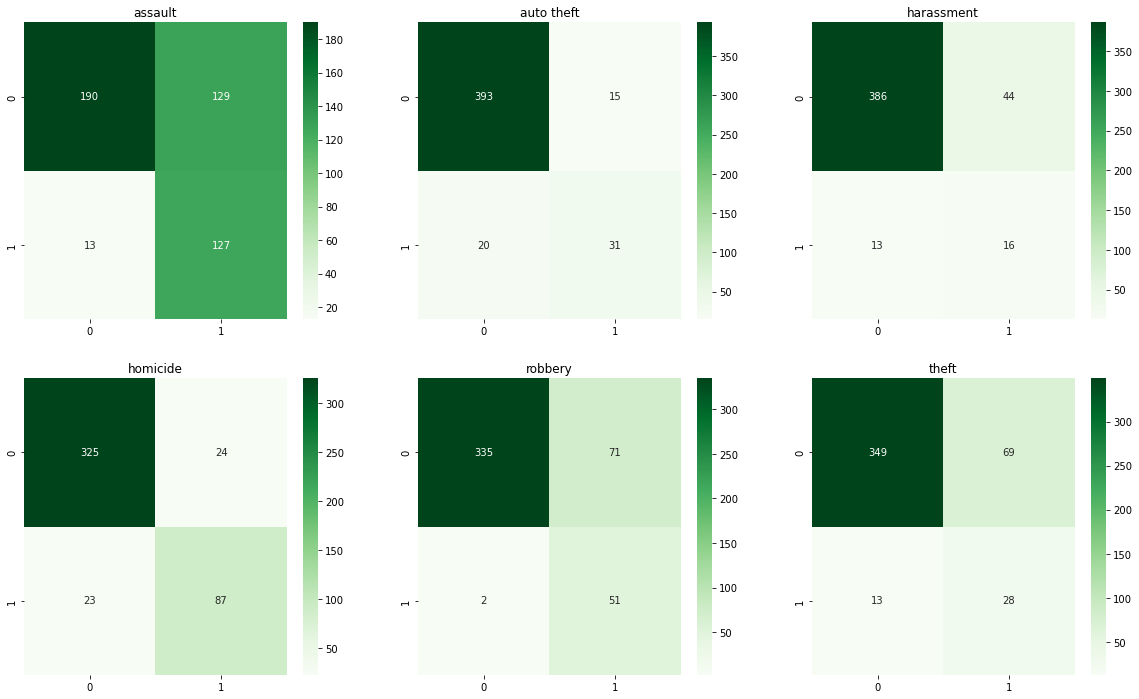

              precision    recall  f1-score   support

     assault       0.50      0.91      0.64       140
  auto theft       0.67      0.61      0.64        51
  harassment       0.27      0.55      0.36        29
    homicide       0.78      0.79      0.79       110
     robbery       0.42      0.96      0.58        53
       theft       0.29      0.68      0.41        41

   micro avg       0.49      0.80      0.61       424
   macro avg       0.49      0.75      0.57       424
weighted avg       0.55      0.80      0.63       424
 samples avg       0.36      0.48      0.39       424



C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nazar\anaconda3\envs\py38dnn\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
cm = multilabel_confusion_matrix(y_true, y_pred)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

for (i, label), ax in zip(enumerate(mlb.classes_), axs.ravel()):
    #row_sums = cm[i].sum(axis=1) 
    #matrix = (cm[i] / row_sums[:, np.newaxis]).round(4)
    sns.heatmap(cm[i], annot=True, fmt='g', ax=ax, cmap='Greens')

    # chart formatting
    ax.set_title(label)
    #ax.get_legend().remove()
    #ax.set_xlabel("")

plt.show()

print(classification_report(y_true, y_pred, target_names=mlb.classes_))